In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
%matplotlib inline

In [17]:
## Getting the Images
imageDir = '/content/drive/MyDrive/simple-lane-detection/test_images'
imageFiles = os.listdir(imageDir)

imageList = [mpimg.imread(os.path.join(imageDir, filename)) for filename in imageFiles]

print(imageFiles)

['solidWhiteCurve.jpg', 'whiteCarLaneSwitch.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve2.jpg']


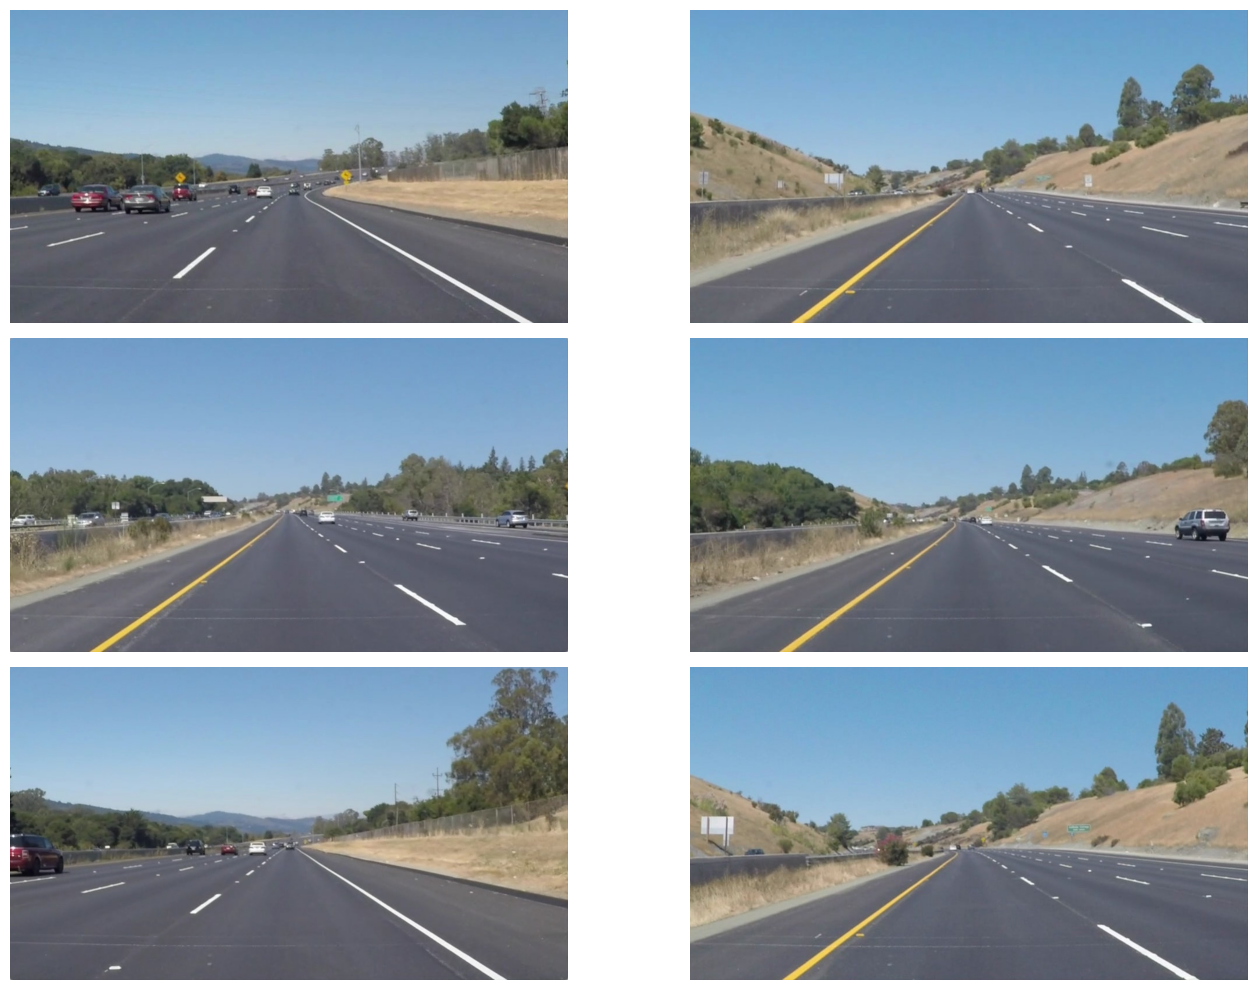

In [18]:
def display_images(images, cmap=None):
    num_images = len(images)
    num_rows = (num_images + 1) // 2
    num_cols = 2

    plt.figure(figsize=(15, 10))

    for i, image in enumerate(images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image, cmap=cmap)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images(imageList)

### Masking Unnecessary Colors


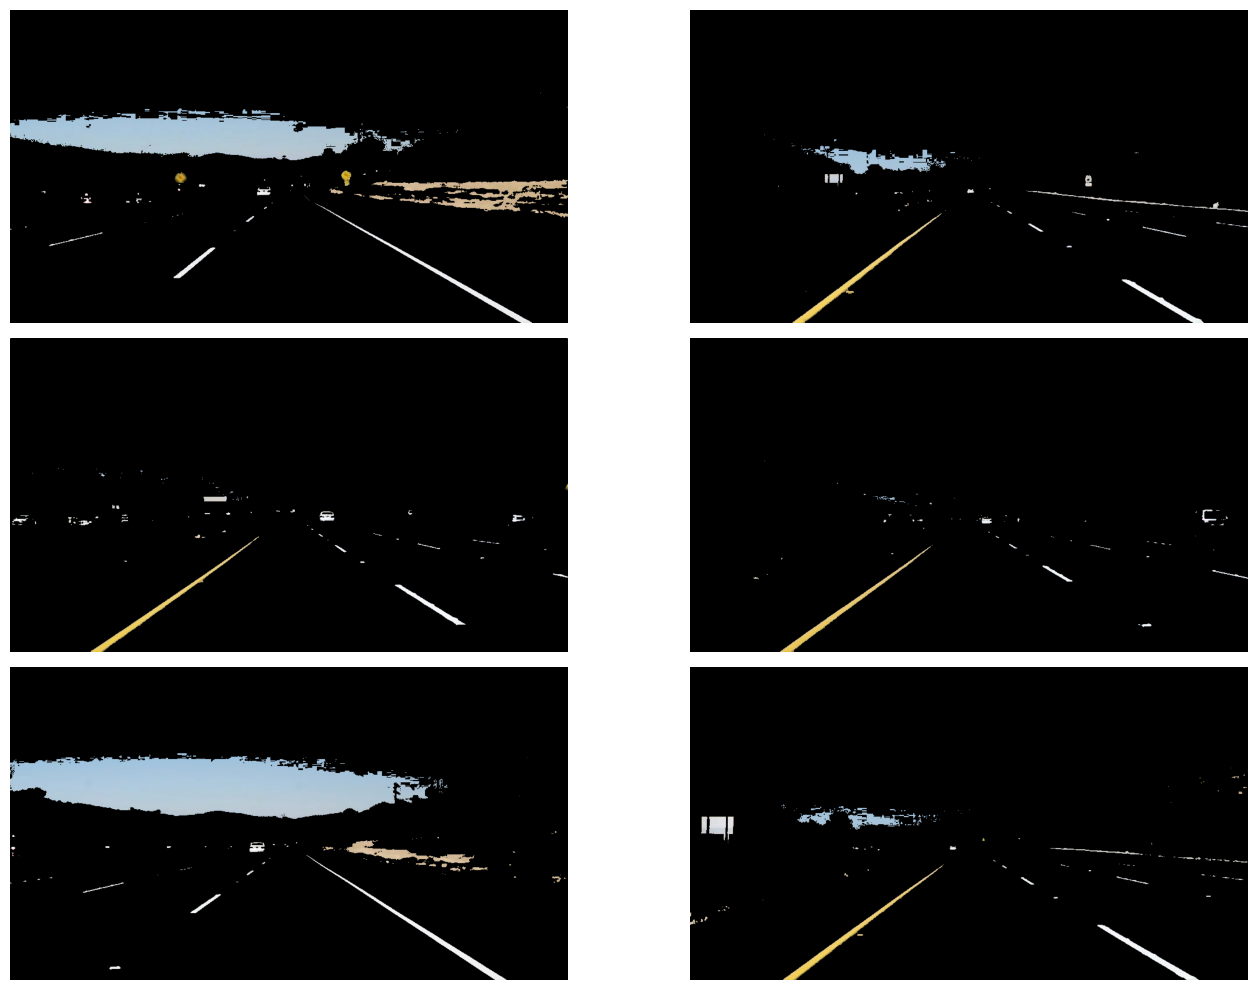

In [19]:
def color_filter(image):
    # Convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    lower_white = np.array([0, 190, 0])
    upper_white = np.array([255, 255, 255])

    lower_yellow = np.array([10, 0, 90])
    upper_yellow = np.array([50, 255, 255])

    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(hls, lower_white, upper_white)

    mask = cv2.bitwise_or(yellow_mask, white_mask)
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    return masked_image

filtered_images = [color_filter(image) for image in imageList]

def display_images(images):
    num_images = len(images)
    num_cols = 2
    num_rows = (num_images + 1) // num_cols

    plt.figure(figsize=(15, 10))

    for i, img in enumerate(images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images(filtered_images)

## Region of Interest


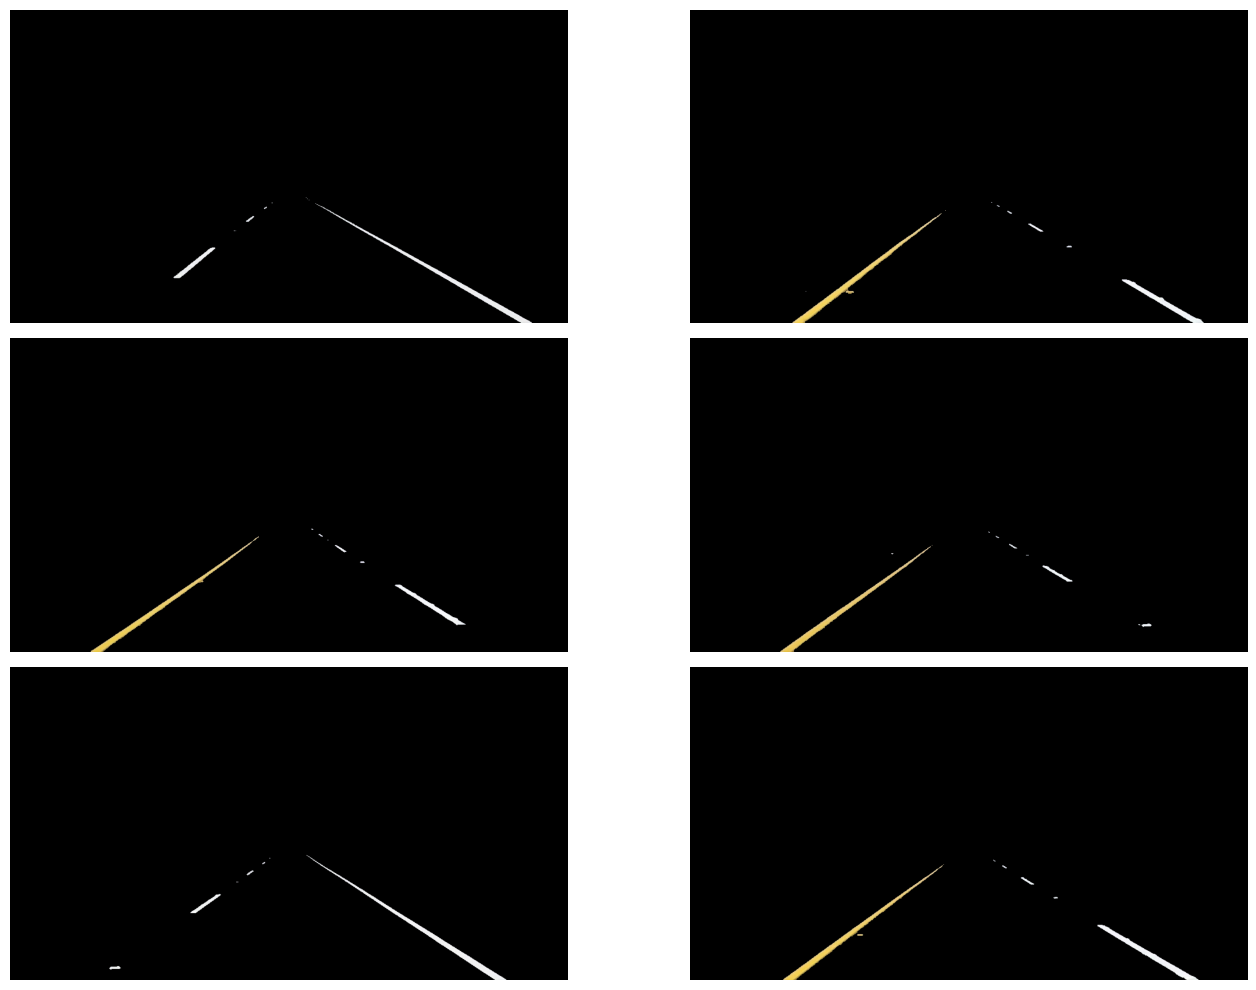

In [20]:
def roi(img):
    x = img.shape[1]
    y = img.shape[0]
    shape = np.array([[0, y], [x, y], [0.55*x, 0.6*y], [0.45*x, 0.6*y]], np.int32)

    # Define a numpy array with the dimensions of img, but comprised of zeros
    mask = np.zeros_like(img)

    # Determine the number of channels
    channel_count = img.shape[2] if len(img.shape) > 2 else 1
    ignore_mask_color = (255,) * channel_count

    # Create a polygon with the mask color
    cv2.fillPoly(mask, [shape], ignore_mask_color)

    # Return the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_images = [roi(img) for img in filtered_images]

def display_images(images):
    num_images = len(images)
    num_cols = 2
    num_rows = (num_images + 1) // num_cols

    plt.figure(figsize=(15, 10))

    for i, img in enumerate(images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images(roi_images)

## Edge Detection

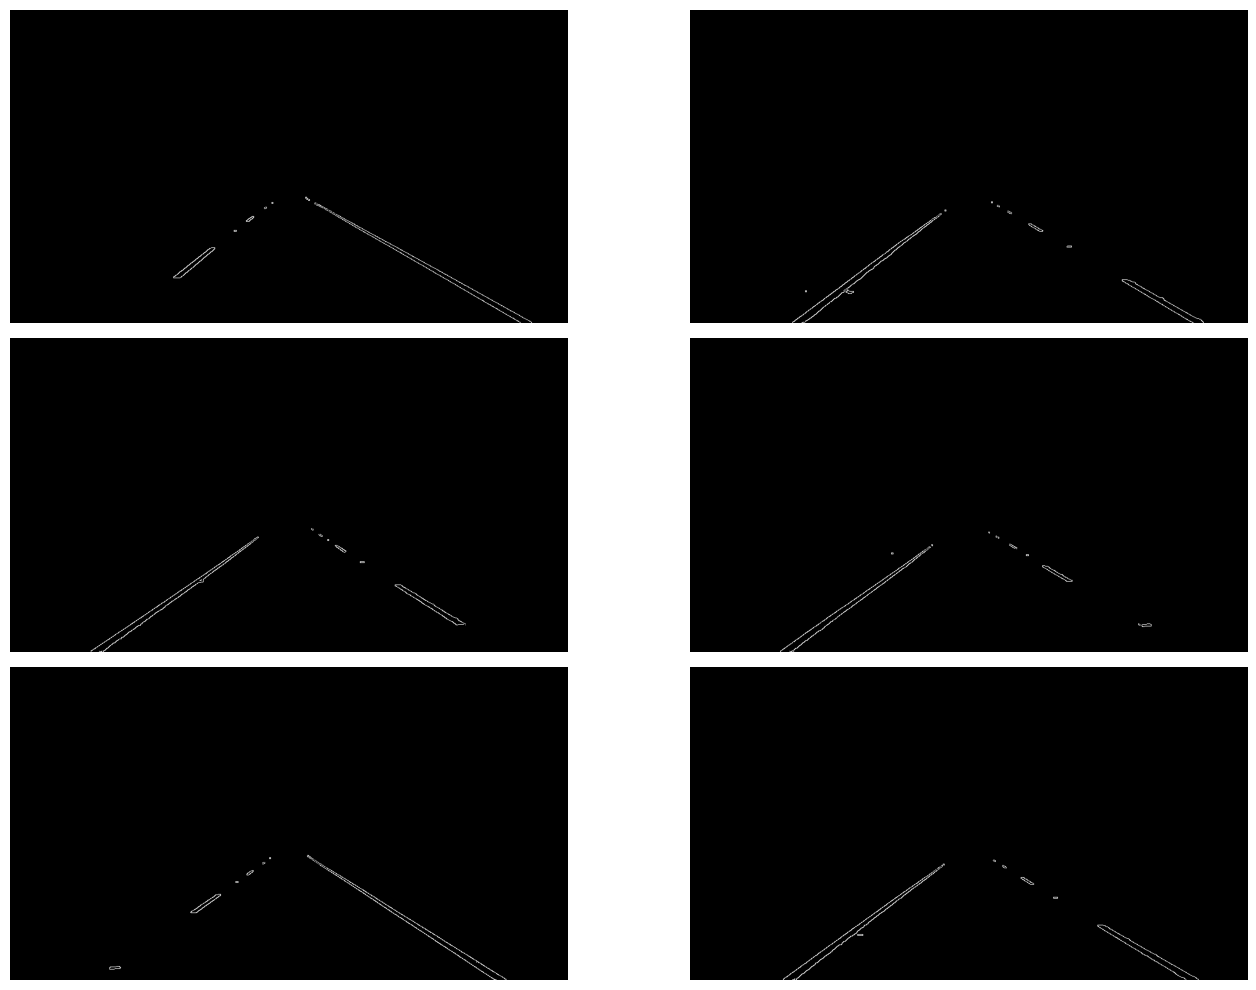

In [21]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img):
    gray = grayscale(img)
    return cv2.Canny(gray, 50, 120)

canny_images = [canny(img) for img in roi_images]

def display_images(images, cmap=None):
    num_images = len(images)
    num_cols = 2
    num_rows = (num_images + 1) // num_cols

    plt.figure(figsize=(15, 10))

    for i, img in enumerate(images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images(canny_images, cmap='gray')

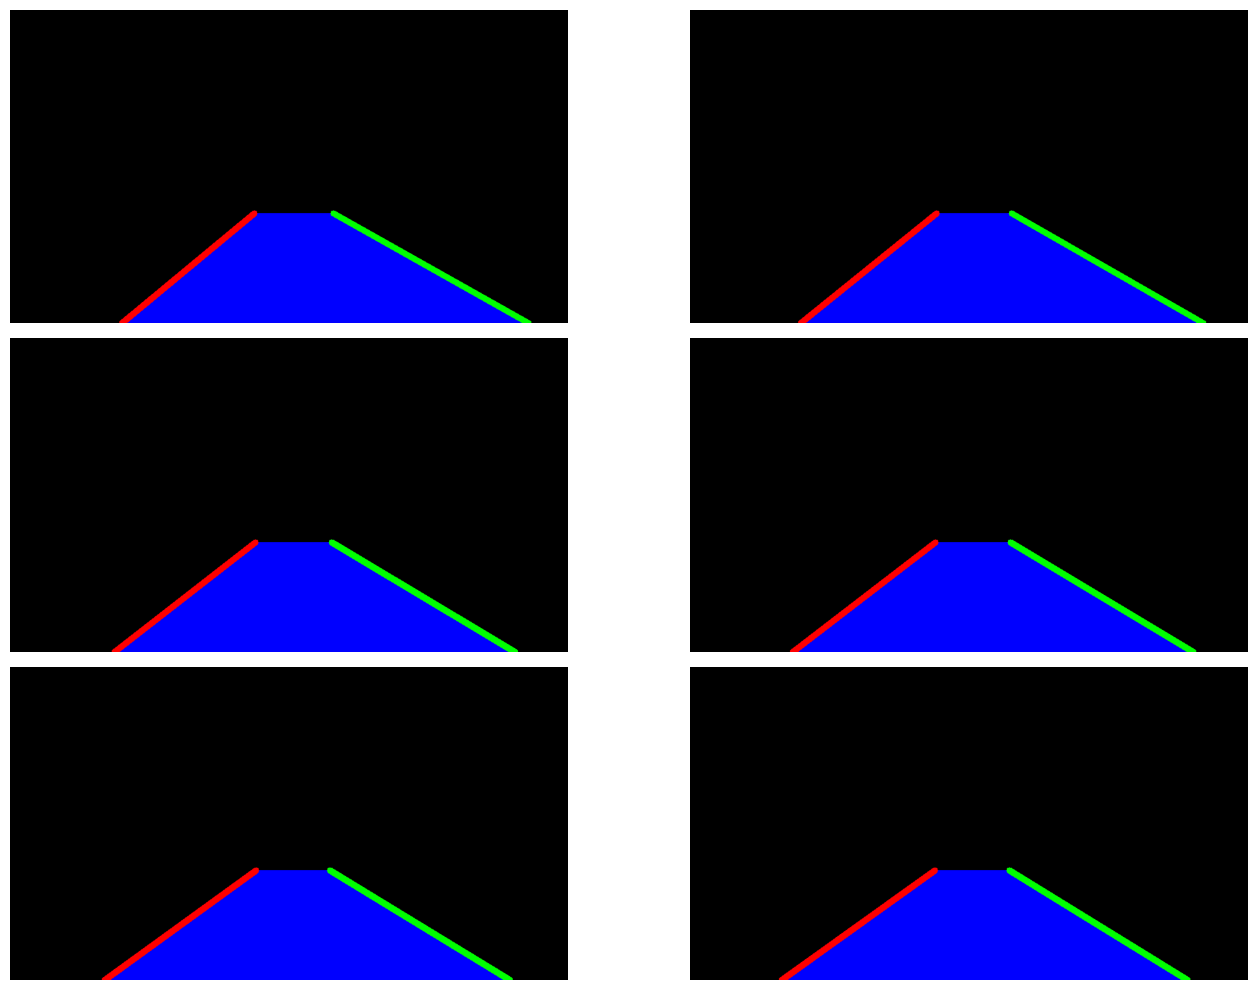

In [22]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]

def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor = [0, 255, 0]
    leftColor = [255, 0, 0]

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y1 - y2) / (x1 - x2)
            if slope > 0.3:
                if x1 > 500:
                    yintercept = y2 - (slope * x2)
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope * x2)
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)

    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])

    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])

    try:
        left_line_x1 = int((0.65 * img.shape[0] - leftavgIntercept) / leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept) / leftavgSlope)

        right_line_x1 = int((0.65 * img.shape[0] - rightavgIntercept) / rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept) / rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65 * img.shape[0])], [left_line_x2, int(img.shape[0])],
                        [right_line_x2, int(img.shape[0])], [right_line_x1, int(0.65 * img.shape[0])]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(img, [pts], (0, 0, 255))

        cv2.line(img, (left_line_x1, int(0.65 * img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65 * img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
        pass

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)

hough_images = [linedetect(img) for img in canny_images]
display_images(hough_images)


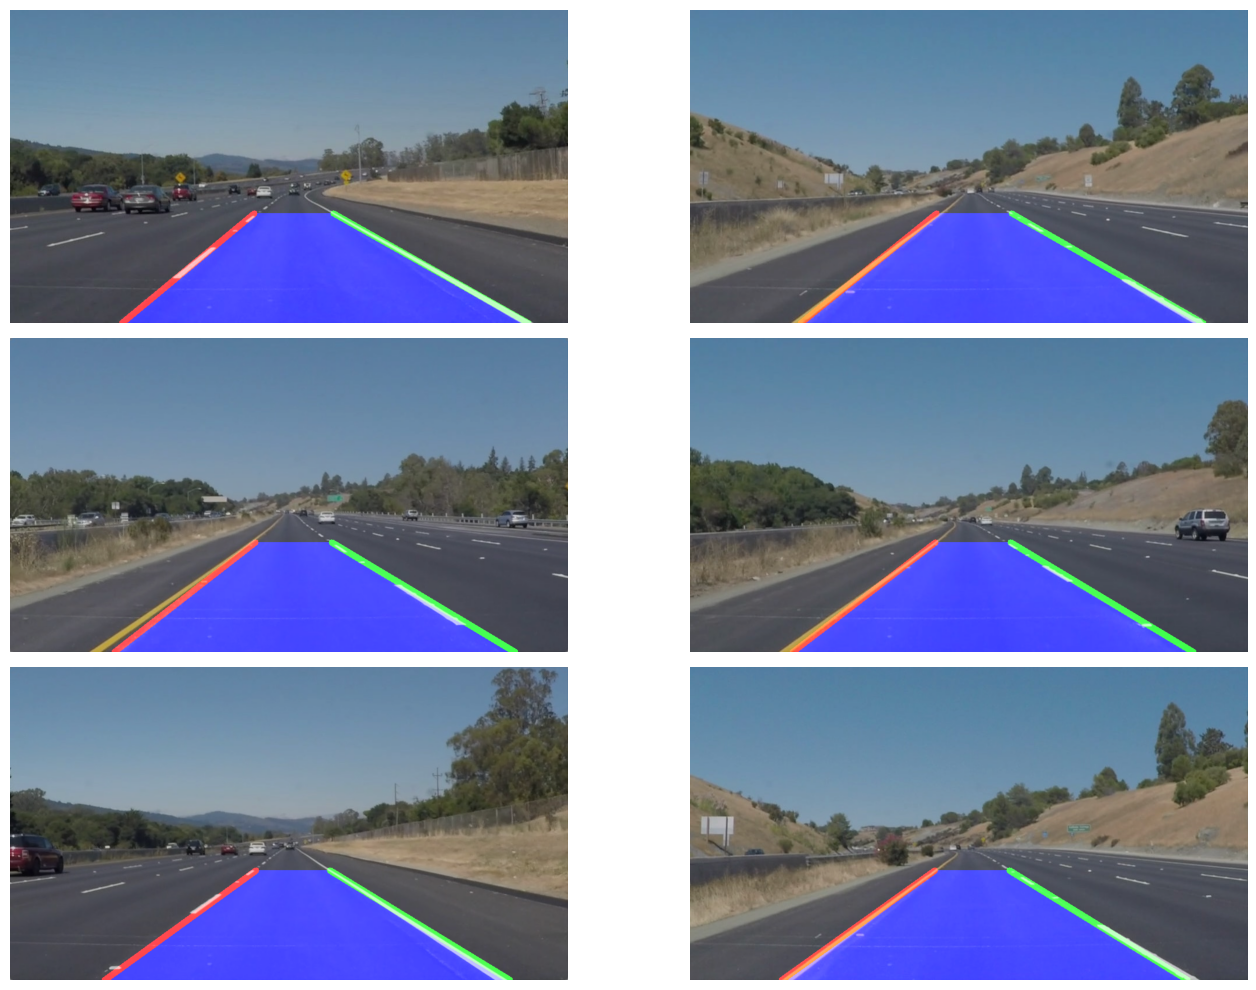

In [23]:
##Overlaying the Image and the Lines
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

# Make copies of the original images
hough_img_copy = [np.copy(img) for img in hough_img]
imageList_copy = [np.copy(img) for img in imageList]

# Perform weighted sum operation without modifying original images
result_img = list(map(weightSum, zip(hough_img_copy, imageList_copy)))
display_images(result_img)

Checking the Model Performance

In [24]:
def processImage(image):
    # Make a copy of the original image
    image_copy = np.copy(image)

    # Apply region of interest
    interest = roi(image_copy)

    # Apply color filtering
    filterimg = color_filter(interest)

    # Convert to grayscale
    gray_img = grayscale(filterimg)

    # Apply Canny edge detection
    canny = cv2.Canny(gray_img, 50, 120)

    # Apply Hough transform to detect lines
    myline = hough_lines(canny, 1, np.pi/180, 10, 20, 5)

    # Blend the detected lines with the original image
    weighted_img = cv2.addWeighted(myline, 1, image_copy, 0.8, 0)

    return weighted_img

In [14]:
import os
from moviepy.editor import VideoFileClip

# Define input and output folder paths
input_folder = "/content/drive/MyDrive/simple-lane-detection/test_videos"
output_folder = "/content/drive/MyDrive/simple-lane-detection/test_videos_output/"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Process each video file in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".mp4"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        clip = VideoFileClip(input_path)
        processed_clip = clip.fl_image(processImage)
        %time processed_clip.write_videofile(output_path, audio=False)

Moviepy - Building video /content/drive/MyDrive/simple-lane-detection/test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video /content/drive/MyDrive/simple-lane-detection/test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/simple-lane-detection/test_videos_output/solidYellowLeft.mp4
CPU times: user 11.5 s, sys: 1.87 s, total: 13.4 s
Wall time: 43.7 s
Moviepy - Building video /content/drive/MyDrive/simple-lane-detection/test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video /content/drive/MyDrive/simple-lane-detection/test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/simple-lane-detection/test_videos_output/solidWhiteRight.mp4
CPU times: user 3.6 s, sys: 577 ms, total: 4.17 s
Wall time: 14.1 s
Moviepy - Building video /content/drive/MyDrive/simple-lane-detection/test_videos_output/challenge.mp4.
Moviepy - Writing video /content/drive/MyDrive/simple-lane-detection/test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/simple-lane-detection/test_videos_output/challenge.mp4
CPU times: user 7.13 s, sys: 913 ms, total: 8.04 s
Wall time: 34.8 s
